In [20]:
!pip install umap-learn

In [21]:
#General Libraries
import pandas as pd
import numpy as np

# Machine Learning & Natural Language Processing
import re

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from nltk.corpus import stopwords
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import TruncatedSVD 

import umap

## Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
df = pd.read_csv('databricks-class.csv')
df.head()

,cluster,url,search_text
0,2,https://docs.gcp.databricks.com/,delta lake and delta engine guide streaming io...
1,0,https://docs.gcp.databricks.com/_static/notebo...,10.5 ml
2,0,https://docs.gcp.databricks.com/administration...,no active google kubernetes engine cluster fou...
3,0,https://docs.gcp.databricks.com/administration...,premium dlt
4,3,https://docs.gcp.databricks.com/administration...,token management personal access token persona...


In [23]:
new_stopwords = ["data","create","configure","cluster"]

[CV 2/3] END rnf_clf__max_depth=10, rnf_clf__min_samples_leaf=1, rnf_clf__n_estimators=10, tfidf_vec__min_df=0.05, tsvd_red__n_components=50;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/3] END rnf_clf__max_depth=10, rnf_clf__min_samples_leaf=1, rnf_clf__n_estimators=100, tfidf_vec__min_df=0.05, tsvd_red__n_components=50;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/3] END rnf_clf__max_depth=10, rnf_clf__min_samples_leaf=1, rnf_clf__n_estimators=200, tfidf_vec__min_df=0.01, tsvd_red__n_components=50;, score=(train=1.000, test=0.957) total time=   1.2s
[CV 2/3] END rnf_clf__max_depth=10, rnf_clf__min_samples_leaf=4, rnf_clf__n_estimators=200, tfidf_vec__min_df=0.01, tsvd_red__n_components=150;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/3] END rnf_clf__max_depth=10, rnf_clf__min_samples_leaf=4, rnf_clf__n_estimators=200, tfidf_vec__min_df=0.01, tsvd_red__n_components=150;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/3] END rnf_clf__max_depth=10, rnf_

In [24]:
X = df['search_text']
y = df['cluster']

X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y, random_state=214 )

In [25]:
y_labels = y_train.unique()
y_labels.sort()

In [26]:
%%time
pipe_red = Pipeline( [( "tfidf_vec", TfidfVectorizer(min_df=0.05, max_df=0.6,
                                                     stop_words=stopwords.words("english")+new_stopwords,
                                                     ngram_range=(1,2)
                                                     ) ),
                      ( "umap_red", umap.UMAP(n_neighbors=15, metric='hellinger', verbose=3) ),
                      ],
                     verbose=3 
                    )

X_train_2d = pipe_red.fit_transform(X_train)

[Pipeline] ......... (step 1 of 2) Processing tfidf_vec, total=   0.0s
UMAP(angular_rp_forest=True, metric='hellinger', verbose=3)
Mon Jul 18 18:16:20 2022 Construct fuzzy simplicial set
Mon Jul 18 18:16:20 2022 Finding Nearest Neighbors
Mon Jul 18 18:16:20 2022 Finished Nearest Neighbor Search
Disconnection_distance = 1 has removed 180720 edges.  This is not a problem as no vertices were disconnected.
Mon Jul 18 18:16:20 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jul 18 18:16:24 2022 Finished embedding
[Pipeline] .......... (step 2 of 2) Processing umap_red, total=   4.5s
CPU times: user 9.92 s, sys: 506 ms, total: 10.4 s
Wall time: 4.51 s


Text(0.5, 1.0, '2D visualization with UMAP')

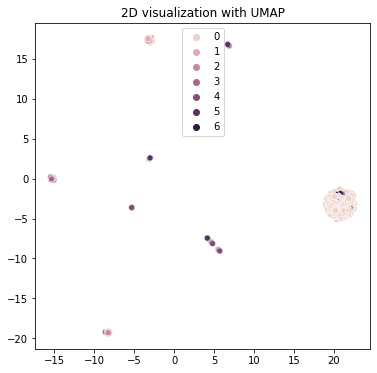

In [27]:
X_train_red_df = pd.DataFrame( data={'x':X_train_2d[:,0], 'y':X_train_2d[:,1], 'area':y_train} )
labels = y_train.unique()

fig, ax = plt.subplots( figsize=(6,6) )

ax = sns.scatterplot(data=X_train_red_df, x='x', y='y', hue='area', 
                     hue_order=labels, 
                     ax=ax 
                    )

plt.legend(loc = "upper center")
ax.set_xlabel("")
ax.set_ylabel("")

ax.set_title("2D visualization with UMAP")

# Classification on TF-IDF & Random Forest Classifier

In [28]:
pipe_clf = Pipeline( [( "tfidf_vec", TfidfVectorizer( stop_words=stopwords.words("english")+new_stopwords) ),
                      ( "tsvd_red", TruncatedSVD (random_state=214) ),
                      ( "rnf_clf", RandomForestClassifier(random_state=214, n_jobs=-1) )
                      ] 
                    )

In [29]:
params = { 
           "tfidf_vec__min_df": [ 0.01, 0.05 ],
           
           "tsvd_red__n_components": [50, 150],
           
           "rnf_clf__n_estimators":[10, 100, 200],
           "rnf_clf__max_depth":[10, 25, 50],
           "rnf_clf__min_samples_leaf":[1, 4, 10]
          }

grid_search = GridSearchCV(pipe_clf, params, cv=3, scoring="accuracy", 
                           verbose=3, return_train_score=True, n_jobs=-1 )

In [30]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 2/3] END rnf_clf__max_depth=10, rnf_clf__min_samples_leaf=1, rnf_clf__n_estimators=10, tfidf_vec__min_df=0.01, tsvd_red__n_components=50;, score=(train=0.998, test=0.947) total time=   0.1s
[CV 2/3] END rnf_clf__max_depth=10, rnf_clf__min_samples_leaf=1, rnf_clf__n_estimators=100, tfidf_vec__min_df=0.05, tsvd_red__n_components=50;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/3] END rnf_clf__max_depth=10, rnf_clf__min_samples_leaf=1, rnf_clf__n_estimators=100, tfidf_vec__min_df=0.05, tsvd_red__n_components=150;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/3] END rnf_clf__max_depth=10, rnf_clf__min_samples_leaf=1, rnf_clf__n_estimators=200, tfidf_vec__min_df=0.01, tsvd_red__n_components=150;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/3] END rnf_clf__max_depth=10, rnf_clf__min_samples_leaf=1, rnf_clf__n_estimators=200, tfidf_vec__min_df=0.05, tsvd_red__n_components=50;, score=(train=nan, test=n

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
243 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
  

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vec',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your

In [31]:
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf_vec',
                 TfidfVectorizer(min_df=0.01,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('tsvd_red', TruncatedSVD(n_components=50, random_state=214)),
                ('rnf_clf',
                 RandomForestClassifier(max_depth=10, n_jobs=-1,
                                        random_state=214))])

In [32]:
y_train_pred = cross_val_predict( best_model, X_train, y_train )

Text(0.5, 1.0, 'Confusion Matrix')

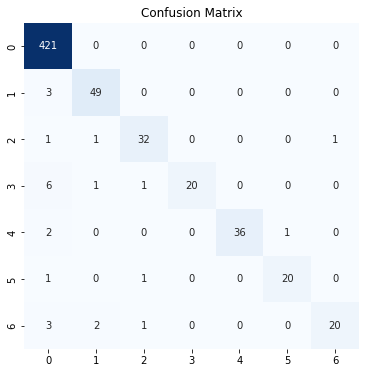

In [33]:
labels = y_train.unique()
confusion_m = confusion_matrix(y_train, y_train_pred, labels=y_labels)

fig, ax = plt.subplots( figsize=(6,6) )

sns.heatmap(confusion_m, annot=True, fmt='d', 
            xticklabels=y_labels, yticklabels=y_labels,
            cmap='Blues', cbar=False,
            ax=ax)

ax.set_title("Confusion Matrix")

In [34]:
print( classification_report(y_train, y_train_pred) )

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       421
           1       0.92      0.94      0.93        52
           2       0.91      0.91      0.91        35
           3       1.00      0.71      0.83        28
           4       1.00      0.92      0.96        39
           5       0.95      0.91      0.93        22
           6       0.95      0.77      0.85        26

    accuracy                           0.96       623
   macro avg       0.96      0.88      0.91       623
weighted avg       0.96      0.96      0.96       623



# TEST DATA 

Text(0.5, 1.0, 'Confusion Matrix\ndas áreas (teste)')

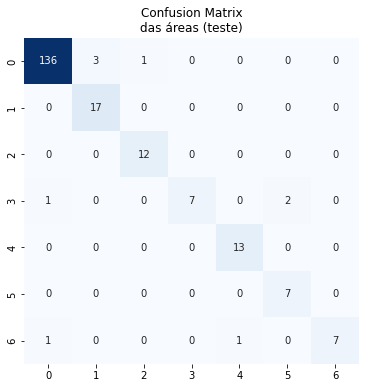

In [35]:
y_test_pred=best_model.predict(X_test)
confusion_m = confusion_matrix(y_test, y_test_pred, labels=y_labels)

fig, ax = plt.subplots( figsize=(6,6) )

sns.heatmap(confusion_m, annot=True, fmt='d', 
            xticklabels=y_labels, yticklabels=y_labels,
            cmap='Blues', cbar=False,
            ax=ax)

ax.set_title("Confusion Matrix\ndas áreas (teste)")

In [38]:
print( classification_report(y_test, y_test_pred) )

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       140
           1       0.85      1.00      0.92        17
           2       0.92      1.00      0.96        12
           3       1.00      0.70      0.82        10
           4       0.93      1.00      0.96        13
           5       0.78      1.00      0.88         7
           6       1.00      0.78      0.88         9

    accuracy                           0.96       208
   macro avg       0.92      0.92      0.91       208
weighted avg       0.96      0.96      0.96       208



In [40]:
titles = ["Unable to access Azure Databricks workspace",
         "Recover Databricks workspace"
         ]
y_predicts = best_model.predict(titles)
y_predicts_proba = best_model.predict_proba(titles)

In [41]:
for text, y_predict, probas in zip( titles, y_predicts, y_predicts_proba ):
    print(f"({y_predict}) {text}")

    for proba, label in zip(probas, y_labels):
        print(f"{label} - {proba:.2f};", end=" ")
    print("\n")

(3) Unable to access Azure Databricks workspace
0 - 0.12; 1 - 0.22; 2 - 0.04; 3 - 0.58; 4 - 0.03; 5 - 0.00; 6 - 0.00; 

(1) Recover Databricks workspace
0 - 0.03; 1 - 0.91; 2 - 0.02; 3 - 0.03; 4 - 0.00; 5 - 0.01; 6 - 0.01; 

